In [89]:
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interpolate
import scipy.io as scio
import numpy as np
import os
import sys
sys.path.append("../ephysSimsPython")
sys.path.append("../SpikeCounter")
import matplotlib.cm as cm
import matplotlib.colors as colors
import colorcet as cc
import pickle
import scipy.optimize as optimize
from parse import *
from detools import detools
import pandas as pd
from spikecounter.ui import visualize
import importlib
# plt.style.use("/mnt/c/Users/billj/voltage_traces.mplstyle")
plt.style.use("../bio_publications.mplstyle")

In [90]:
def reload_libraries():
    importlib.reload(visualize)

In [92]:
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure3/ChR response simulation"
os.makedirs(figdir, exist_ok=True)

In [3]:
params = {}
params["snic"] = {
    "E_rev": np.array([-80, 60, -90]),
    "n_h": -25,
    "g": np.array([8, 20, 10]),
    "m_h": -20,
    "k_m": 15,
    "k_n": 5,
    "tau": 1,
    "C": 1,
    "D":1,
    "I": None,
    "V_init": -61,
    "n_init": 0.01
}

params["saddle_node"] = {
    "E_rev": np.array([-80, 60, -90]),
    "n_h": -25,
    "g": np.array([8, 20, 10]),
    "m_h": -20,
    "k_m": 15,
    "k_n": 5,
    "tau": 0.14,
    "tau": 0.159,
    "C": 1,
    "D":0.1,
    "I": None,
    "V_init": -62,
    "n_init": 0.01
}
params["supercritical_hopf"] = {
    "E_rev": np.array([-78, 60, -90]),
    "n_h": -45,
    "g": np.array([8, 22, 10]),
    "m_h": -23.4,
    "k_m": 12.826,
    "k_n": 5,
    "tau": 1,
    "C": 1,
    "D":1,
    "I": None,
    "V_init": -55,
    "n_init": 0.1
}
params["subcritical_hopf"] = {
    "E_rev": np.array([-78, 60, -90]),
    "n_h": -45,
    "g": np.array([1, 4, 4]),
    "m_h": -30,
    "k_m": 7,
    "k_n": 5,
    "tau": 1,
    "C": 1,
    "D":0.05,
    "I": None,
    "V_init": -49,
    "n_init": 0.3
}
params["subcritical_hopf2"] = {
    "E_rev": np.array([-78, 60, -90]),
    "n_h": -45,
    "g": np.array([1, 4, 4]),
    "m_h": -30,
    "k_m": 7,
    "k_n": 5,
    "tau": 1,
    "C": 1,
    "D":0.1,
    "I": None,
    "V_init": -49,
    "n_init": 0.3
}


In [4]:
def gen_ramp(min_val, max_val, duration):
    def ramp(x, t):
        return min_val + (max_val-min_val)*min(1,t/duration)
    return ramp

In [5]:
def onecell_euler(de, ts, dt, y0):
    t = np.arange(ts[0], ts[1], step=dt)
    y = np.zeros((len(t), len(y0)))
    y[0,:] = y0
    print(y.shape)
    for i in range(1,len(t)):
        y[i,:] = y[i-1,:] + np.array(de(y[i-1,0], y[i-1,1], t[i]))*dt
    return t, y

In [56]:
def input_func(x,t, stim_mag, period, duration, sigma):
    y = np.random.randn()*sigma + ((t - np.floor(t/period)*period) < duration*0.8)* stim_mag
    return y

(0.0, 100.0)

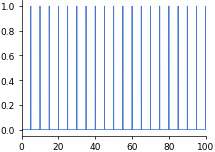

In [33]:
plt.plot(t,(t-np.floor(t/period)*period) < dt*0.8)
plt.xlim(0, 100)

In [8]:
curr_params = params["snic"]
del curr_params["V_init"]
del curr_params["n_init"]

(250000, 2)
(250000, 2)


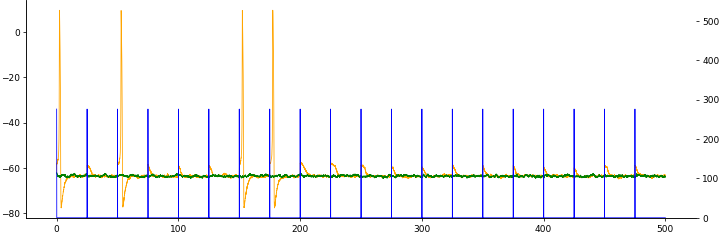

In [80]:
curr_params["I"] = 3.2

sigma = 10
duration = 500
stim_mag = 276
period = 25
dt = 0.002

snic_dE = detools.gen_ode(**curr_params, f = lambda x,t: input_func(x,t,stim_mag,period,10*dt,sigma))
t, y = onecell_euler(snic_dE, (0,duration), dt, \
                     np.random.randn(2)*np.array([0, 0]) + \
                     np.array([-62, 0]))

snic_dE_endo = detools.gen_ode(**curr_params, f = lambda x,t: input_func(x,t,0,period,dt,sigma))
t_endo, y_endo = onecell_euler(snic_dE_endo, (0,duration), dt, \
                     np.random.randn(2)*np.array([0, 0]) + \
                     np.array([-62, 0]))

fig1, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
stim = input_func(y,t,stim_mag,period,dt,0)
ax2.plot(t,stim, color="blue")
ax2.set_ylim(0, np.max(stim)*2)

ax1.plot(t,y[:,0], color="orange")
ax1.plot(t_endo,y_endo[:,0], color="green")
# ax1.set_axis_off()
# plt.savefig(os.path.join(figdir, "Figure5", "snic_ramp.svg"))

## Analyze parameter sweep simulation data

In [81]:
datadir = "/n/holyscratch01/cohen_lab/bjia/20230314_MorrisLecar_stim/"

In [87]:
all_data = []
bif = "snic"
for file in os.listdir(datadir):
    params = parse("%s_sigma_{sigma:f}_I_{I:f}.npz" % bif,  file)
    if params is not None:
        try:
            res = np.load(os.path.join(datadir, file))
        except Exception as e:
            print(file)
            continue
        all_data.append((bif, params['I'], params['sigma'], res['isi_mu'], res['isi_std'], \
                         res['isi_std']/res['isi_mu'], res['f'], res['n_peaks'], res["stim_response_prob"]))
all_data = pd.DataFrame(all_data, columns = ["bifurcation", "I", "sigma", "isi_mu", "isi_std", "isi_cv",\
                                             "freq", "n_peaks", "response_prob"])


/tmp/ipykernel_249894/1659337162.py:12: RuntimeWarning: invalid value encountered in true_divide
  res['isi_std']/res['isi_mu'], res['f'], res['n_peaks'], res["stim_response_prob"]))


In [93]:
all_data.to_csv(os.path.join(figdir, "simulated_stim_response_statistics.csv"))

In [95]:
reload_libraries()

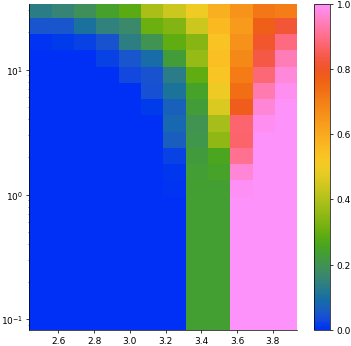

In [97]:
fig1, ax1 = plt.subplots(figsize=(6,6))
visualize.plot_heatmap(all_data, "response_prob", "sigma", "I", ax1)
ax1.set_xscale("linear")